# Chapter 1 Exploratory Data Analysis

This notebook contains all of our ideas for what should be included in the EDA.

Business Question: 
Which pre-release movie characteristics most strongly drive box-office profitability?

Research Question:
How accurately can machine-learning models predict movie profitability using metadata, cast features, and review-related information?

Sub-Questions:
1) (Iro):  Which pre-release characteristics, especially genre and cast composition, most strongly predict a movie’s profitability?
2) (Rosie):  How do user and critic review patterns and rating metrics values differ between profitable and non-profitable movies?
3) (Jun): Which movie groups perform the highest in regards to box office success, reviews and awards earned?						

In [1]:
#Library Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from difflib import SequenceMatcher

In [2]:
#Reading the files
df_exreviews = pd.read_excel(os.path.join("..", "Metacritic dataset", "ExpertReviews.xlsx"))
df_metaclean = pd.read_excel(os.path.join("..", "Metacritic dataset", "metaClean43Brightspace.xlsx"))
df_sales = pd.read_excel(os.path.join("..", "Metacritic dataset", "sales.xlsx"))
df_usreviews = pd.read_excel(os.path.join("..", "Metacritic dataset", "UserReviews.xlsx"))


EDA Scope: 

- What variables matter
- What needs cleaning
- What transformations are useful
- Where the outliers are
- What the relationships look like

We should anser these questions in the notebook

## 1.1 MetaCritic Data Analysis (Jun)

Number of rows to columns: (11364, 13)

Number of missing values in dataset:
url              0 (0.0%)
title            0 (0.0%)
studio         350 (3.1%)
rating        1067 (9.4%)
runtime        255 (2.2%)
cast         3702 (32.6%)
director        14 (0.1%)
genre           20 (0.2%)
summary      5897 (51.9%)
awards       6977 (61.4%)
metascore        0 (0.0%)
userscore    2105 (18.5%)
RelDate          0 (0.0%)
dtype: object


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28


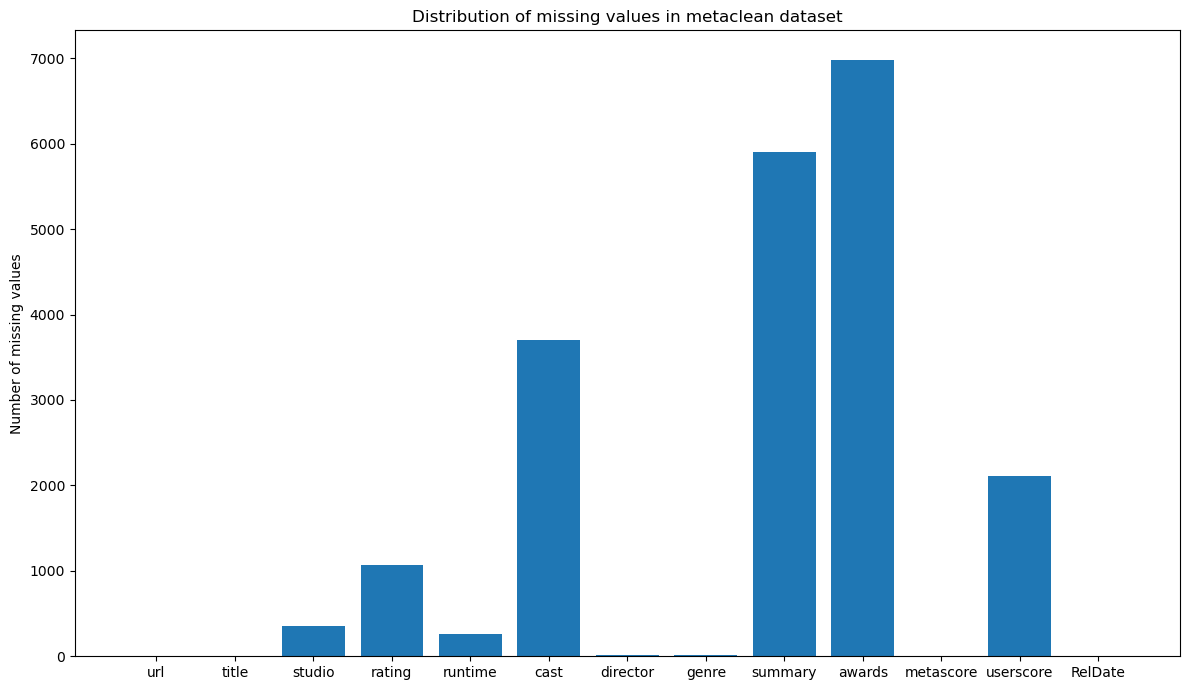

In [4]:
#General number of rows and columns
print("Number of rows to columns:", df_metaclean.shape)
print("")

#Number and percent of missing values
print("Number of missing values in dataset:") 
metaclean_missing_values = df_metaclean.isna().sum()
metaclean_missing_percentage = (df_metaclean.isna().mean() * 100).round(1)
missing_formatted = metaclean_missing_values.astype(str) + " (" + metaclean_missing_percentage.astype(str) + "%)"
print(missing_formatted)

#General shape of dataset
display(df_metaclean.head())

#Plot percentage of missing values per colums
plt.figure(figsize=(12, 7))
plt.bar(metaclean_missing_values.index, metaclean_missing_values)
plt.title("Distribution of missing values in metaclean dataset")
plt.ylabel("Number of missing values")
plt.tight_layout()
plt.show()



In [ ]:
#Check for duplicated movie url
duplicate_urls = df_metaclean[df_metaclean["url"].duplicated(keep=False)].sort_values("url")

print("Duplicate URLs:")
print(duplicate_urls if not duplicate_urls.empty else "None\n")

#Check for duplicated movie title
duplicate_titles = df_metaclean[df_metaclean["title"].duplicated(keep=False)].sort_values("title")

print("Duplicate Titles:")
print(duplicate_titles if not duplicate_titles.empty else "None\n")

#Check for near identical matches for movie titles
unique_title = df_metaclean["title"].dropna().unique()

similar_titles = []
threshold = 0.95        #Threshold for strictness (0-1)

for i, t1 in enumerate(unique_title):
    for j in range(i + 1, len(unique_title)):
        t2 = unique_title[j]

        #Filter for if length is very high
        if abs(len(t1) - len(t2)) > 10:
            continue
    
        ratio = SequenceMatcher(None, t1, t2).ratio()
        if ratio >= threshold:
            similar_titles.append((t1, t2, ratio))

similar_titles_df = pd.DataFrame(similar_titles, columns=["title 1", "title 2", "Similarity"])
print(f"Found {len(similar_titles_df)} similar title pairs with similarity => {threshold}")
display(similar_titles_df.head())

Duplicate URLs:
None

Duplicate Titles:
                                                     url            title  \
215     https://www.metacritic.com/movie/a-family-affair  A Family Affair   
216    https://www.metacritic.com/movie/a-family-affa...  A Family Affair   
422                https://www.metacritic.com/movie/adam             Adam   
423           https://www.metacritic.com/movie/adam-2019             Adam   
451               https://www.metacritic.com/movie/after            After   
...                                                  ...              ...   
11227   https://www.metacritic.com/movie/wrong-turn-2021       Wrong Turn   
11311             https://www.metacritic.com/movie/youth            Youth   
11312        https://www.metacritic.com/movie/youth-2017            Youth   
11360              https://www.metacritic.com/movie/zoom             Zoom   
11361         https://www.metacritic.com/movie/zoom-2016             Zoom   

                             studio

KeyboardInterrupt: 


===== STUDIO =====
                                         Rarity count  Percentage
studio                                                           
IFC Films                                         408        3.70
Universal Pictures                                345        3.13
Sony Pictures Classics                            344        3.12
Warner Bros. Pictures                             302        2.74
Netflix                                           301        2.73
...                                               ...         ...
Mill Creek Entertainment                            1        0.01
American International Pictures                     1        0.01
Dartmouth Films                                     1        0.01
Fox Lorber Home Video                               1        0.01
20th Century Fox International Classics             1        0.01

[1118 rows x 2 columns]

===== Rare Categories (<1%) =====
                                         Rarity count  Percent

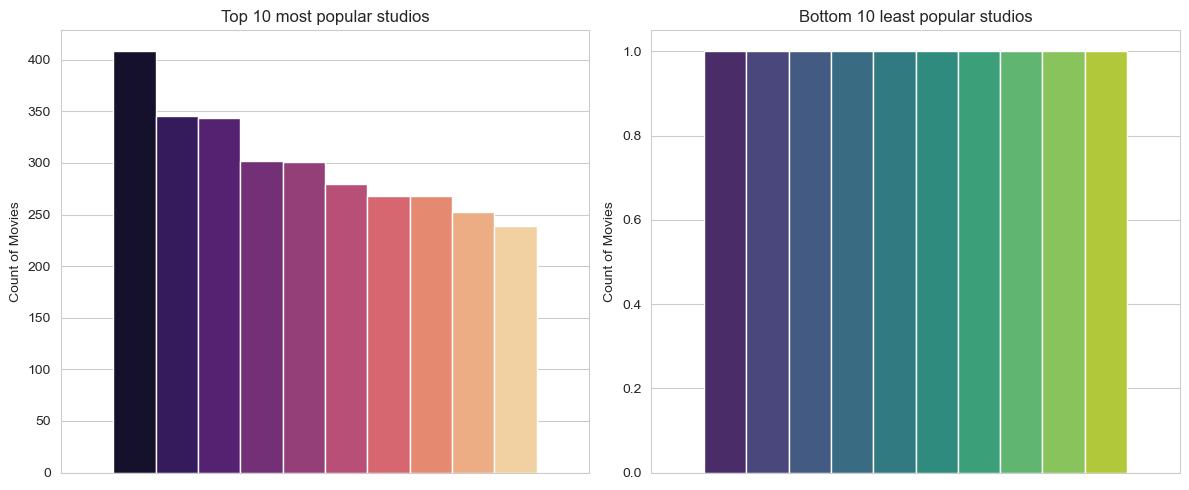

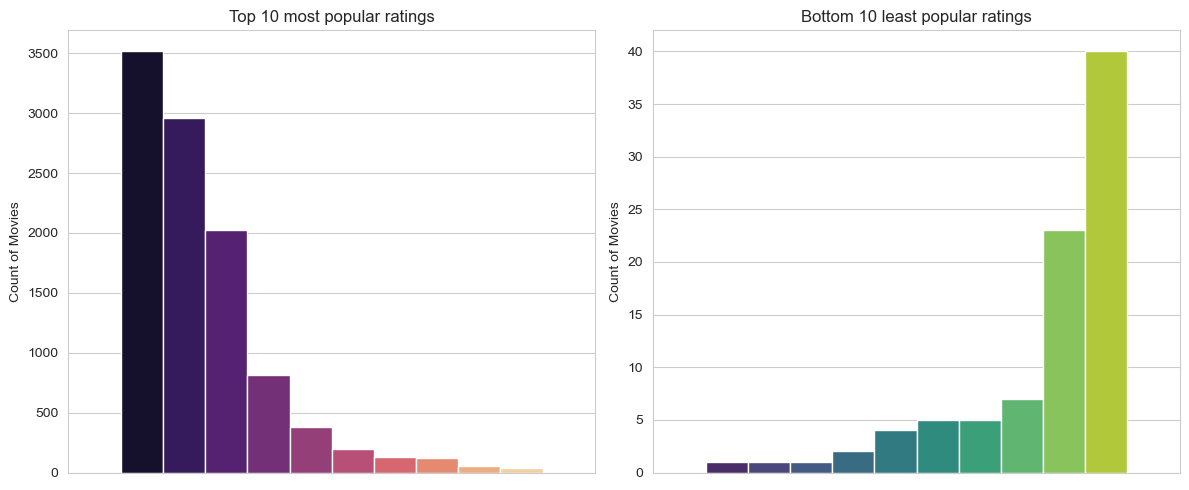

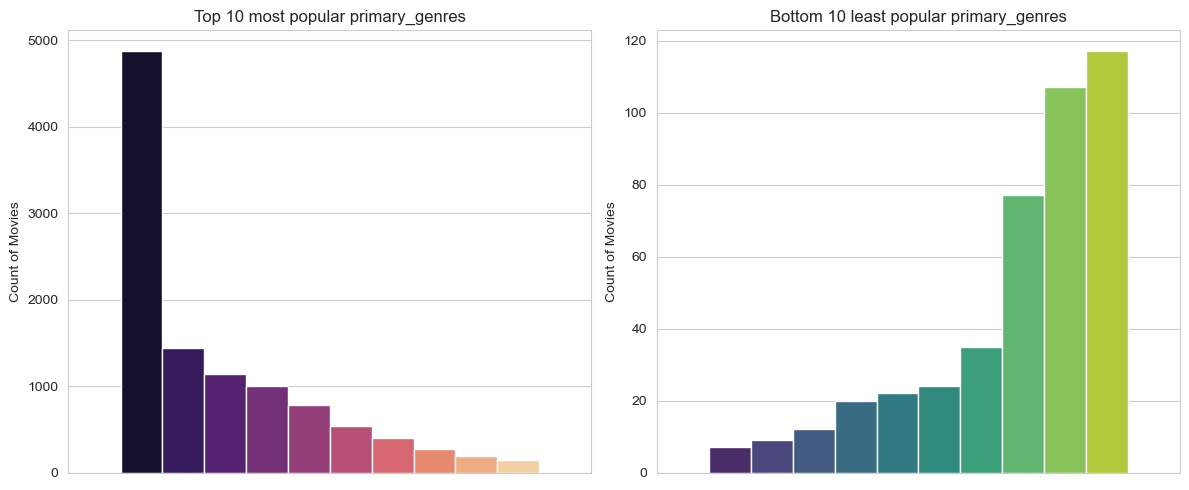

In [7]:
#Check studio, rating and genre for popularity
#Clean genres column
def clean_genre(g):
    if pd.isna(g):
        return np.nan

    #Split based on multiple separators
    parts = re.split(r',|/|\||;| & | - ', g)

    #Strip any whitespaces and remove empty strings
    parts = [p.strip() for p in parts if p.strip() != ""]

    return parts

df_metaclean["clean_genre"] = df_metaclean["genre"].apply(clean_genre)

#Create flat version which contains a single string per movie (based on first genre)
df_metaclean["primary_genre"] = df_metaclean["clean_genre"].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)

popularity_columns = ["studio", "rating", "primary_genre"]

def rarity_check(df_metaclean, col, rarity_threshold=0.01):
    print(f"\n===== {col.upper()} =====")

    #Popularity counts and percentages
    popularity_count = df_metaclean[col].value_counts(dropna=True)
    popularity_percentage = (
        df_metaclean[col].value_counts(normalize=True, dropna=True) * 100).round(2)

    #Print summary
    popularity_summary = pd.DataFrame({"Rarity count": popularity_count, "Percentage": popularity_percentage})
    print(popularity_summary)

    #Detect rare categories
    rare = popularity_summary[popularity_summary["Percentage"] < (rarity_threshold * 100)]
    print("\n===== Rare Categories (<1%) =====")
    print(rare if not rare.empty else "None")

    return popularity_summary, rare

#Run rarity check again
categorical_profiles = {}
for col in popularity_columns:
    categorical_profiles[col] = rarity_check(df_metaclean, col)

#Visualization for genres, studios and ratings
def plot_top10_bottom10_forall_v2(popularity_summarry, col):
    sns.set_style("whitegrid")
    top10_data = popularity_summarry.nlargest(10, 'Rarity count')
    bottom10_data = popularity_summarry.nsmallest(10, 'Rarity count')

    plt.figure(figsize=(12, 5))

    #Plot for top 10
    plt.subplot(1, 2, 1)
    sns.barplot(hue=top10_data.index, y=top10_data['Rarity count'], palette="magma", legend=False)
    plt.title(f"Top 10 most popular {col}s")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count of Movies")
    plt.tight_layout()

    #Plot for bottom 10
    plt.subplot(1, 2, 2)
    sns.barplot(hue=bottom10_data.index, y=bottom10_data['Rarity count'], palette="viridis", legend=False)
    plt.title(f"Bottom 10 least popular {col}s")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count of Movies")
    plt.tight_layout()
    plt.show()

#Generate plots 
for col in popularity_columns:
    popularity_summarry, _ = categorical_profiles[col]
    plot_top10_bottom10_forall_v2(popularity_summarry, col)

,metascore,userscore
count,11364.000000,9259.000000
mean,58.392555,6.542672
std,16.898457,1.374956
min,1.000000,0.200000
25%,47.000000,5.800000
50%,60.000000,6.700000
75%,71.000000,7.500000
max,100.000000,9.700000


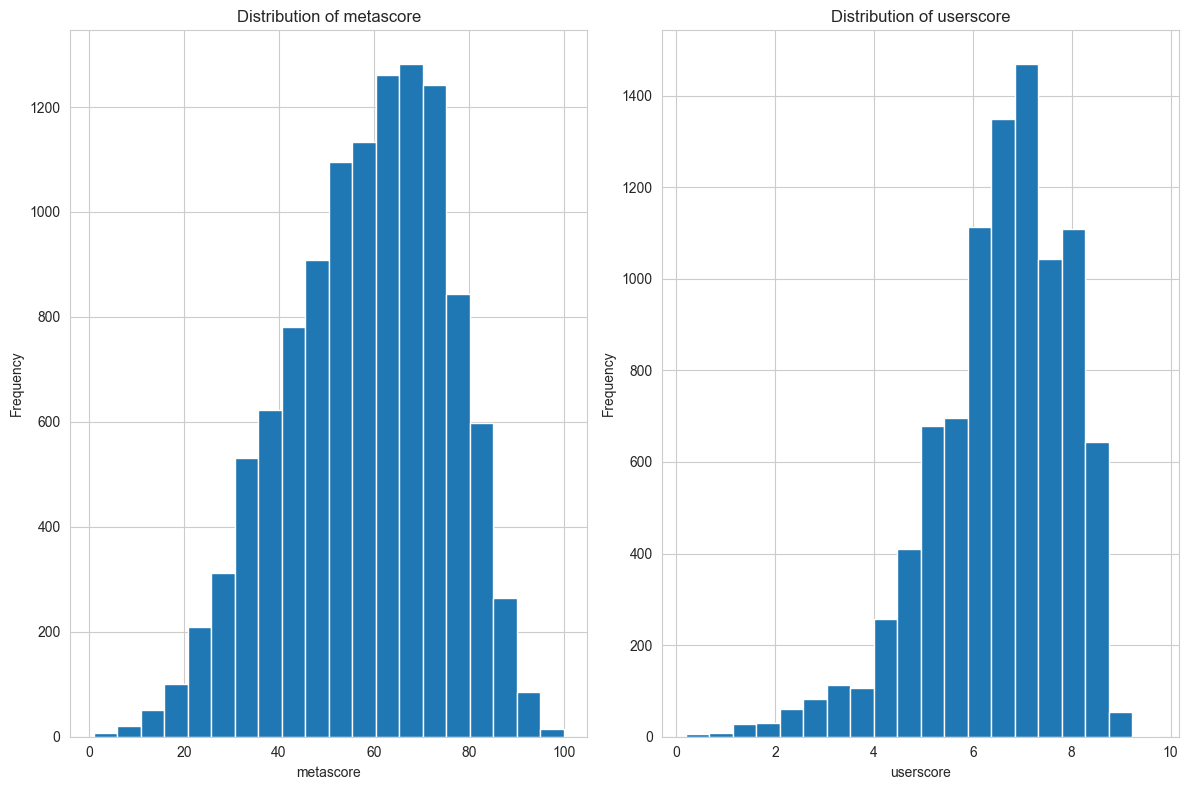

In [ ]:
#Distribution of scores
score_columns = ["metascore", "userscore"]
display(df_metaclean[score_columns].describe())

#Plot histogram for meta and userscores
plt.figure(figsize=(12,8))

for i, col in enumerate(["metascore", "userscore"], 1):
    plt.subplot(1, 2, i)
    plt.hist(df_metaclean[col].dropna(), bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 1.2   Expert Reviews Data Analysis (Rosie)

In [13]:

#  Shape of the dataset
n_rows, n_cols = df_exreviews.shape
print(f"Number of rows   : {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Dataset shape   : {df_exreviews.shape}")

#  Missing values (count & percentage)
missing_count = df_exreviews.isna().sum()
missing_percent = (missing_count / n_rows * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent
}).sort_values("missing_count", ascending=False)

print("\nMissing values summary:")
display(missing_summary)




Number of rows   : 238973
Number of columns: 5
Dataset shape   : (238973, 5)

Missing values summary:


,missing_count,missing_percent
idvscore,2,0.0
reviewer,2,0.0
dateP,2,0.0
Rev,2,0.0
url,0,0.0


Cleaned column names: ['url', 'idvscore', 'reviewer', 'datep', 'rev', 'datep_clean']

After cleaning (sample):


,url,idvscore,reviewer,datep,rev,datep_clean
0,https://www.metacritic.com/movie/bronson,100.0,andrew o'hehir,NaT,'bronson owes a little or a lot to kubrick s c...,NaN
1,https://www.metacritic.com/movie/bronson,90.0,a.o. scott,NaT,'bronson invites you to admire its protagonist...,NaN
2,https://www.metacritic.com/movie/bronson,90.0,<NA>,NaT,'whether it s peterson/bronson s more theatric...,NaN
3,https://www.metacritic.com/movie/bronson,83.0,noel murray,NaT,'there are two bronsons on display here: the i...,NaN
4,https://www.metacritic.com/movie/bronson,80.0,joshua rothkopf,NaT,'refn has somehow found his way to an authenti...,NaN


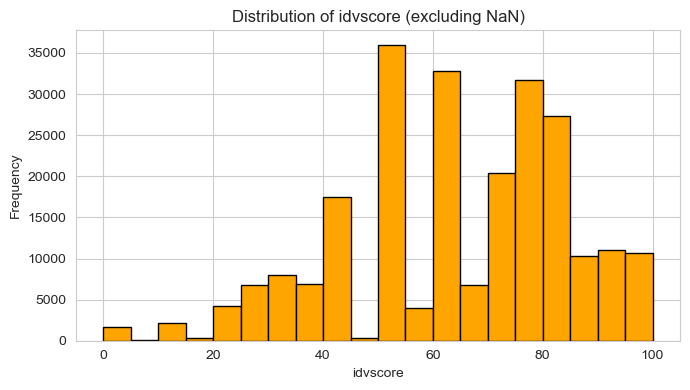

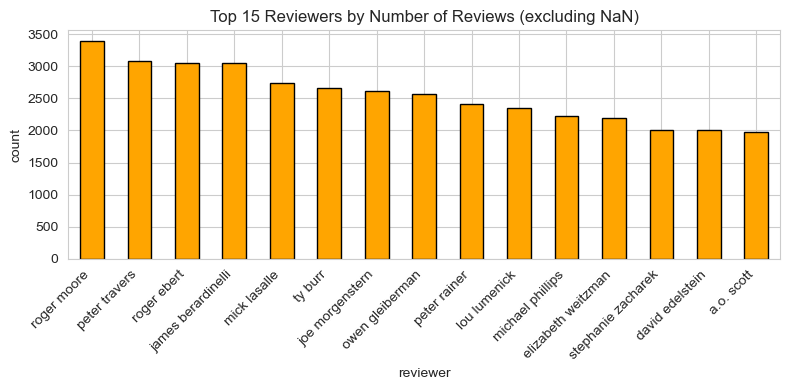

In [19]:
#  Clean column names (multiple separators + whitespace)
df_exreviews.columns = (
    df_exreviews.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"[\/\-\.\s]+", "_", regex=True)   # Replace any sequence of slashes, dashes, dots, or spaces with a single underscore _
    .str.replace(r"[^0-9a-z_]", "", regex=True)     
    .str.replace(r"_+", "_", regex=True)           
    .str.strip("_")                                #Remove underscores from the beginning and the end of the string only
)

print("Cleaned column names:", df_exreviews.columns.tolist())

# replace empty values with NA
_empty_like = ["", " ", "none", "null", "nan", "na", "n/a", "-", "--", "<na>", "<NA>"]

#  Clean URL (lowercase + trim - only keep punctuation like : / .) -keep the format of url
if "url" in df_exreviews.columns:
    df_exreviews["url"] = (
        df_exreviews["url"]
        .astype("string")
        .str.strip()
        .str.lower()
    )
    df_exreviews["url"] = df_exreviews["url"].replace(_empty_like, pd.NA)

# Clean text columns (reviewer, rev): trim, normalize spaces, remove empty 
for col in ["reviewer", "rev"]:
    if col in df_exreviews.columns:
        s = df_exreviews[col]

        # keep true missing as missing
        s = s.astype("string")

        # clean strings
        s = (
            s.str.strip()
            .str.lower()
            .str.replace(r"\s+", " ", regex=True)  # normalize whitespace
        )
        s = s.replace(_empty_like, pd.NA)
        df_exreviews[col] = s

if "reviewer" in df_exreviews.columns:
    df_exreviews["reviewer"] = (
        df_exreviews["reviewer"]
        .str.strip('"')
        .str.strip("'")
    )

#  Clean numeric column (idvscore)
if "idvscore" in df_exreviews.columns:
    df_exreviews["idvscore"] = pd.to_numeric(df_exreviews["idvscore"], errors="coerce")

#  Clean date column differently / YYYY-MM-DD
if "datep" in df_exreviews.columns:
    dp = df_exreviews["datep"]

    dp = dp.astype("string")

    dp = (
        dp.str.strip()
        .str.lower()
        .replace(_empty_like, pd.NA)
    )

    df_exreviews["datep"] = pd.to_datetime(dp, errors="coerce")
    fallback = pd.to_datetime(dp, format="%b %d %Y", errors="coerce")
    df_exreviews["datep"] = df_exreviews["datep"].fillna(fallback)

    df_exreviews["datep_clean"] = df_exreviews["datep"].dt.strftime("%Y-%m-%d")

print("\nAfter cleaning (sample):")
display(df_exreviews.head())

# Popularity: idvscore (distribution) -except Nan 
if "idvscore" in df_exreviews.columns:
    plt.figure(figsize=(7, 4))
    df_exreviews["idvscore"].dropna().plot(kind="hist", bins=20, color="orange", edgecolor="black")
    plt.title("Distribution of idvscore (excluding NaN)")
    plt.xlabel("idvscore")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Popularity: reviewer (top 15) 
if "reviewer" in df_exreviews.columns:
    top_reviewers = df_exreviews["reviewer"].dropna().value_counts().head(15)

    plt.figure(figsize=(8, 4))
    top_reviewers.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("Top 15 Reviewers by Number of Reviews (excluding NaN)")
    plt.xlabel("reviewer")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Conclusion of Exploratory Data Analysis

The Expert Reviews dataset comprises 238,973 rows and five columns: url, idvscore, reviewer, datep, and rev.
The dataset has minimal missing data, with only 2 missing values. Consequently, missing-value visualisation was necessary.
Analysis of duplicate values indicated that duplicate URLs or other column values do not represent redundant information. Reviews linked to the same movie URL exhibit different review scores and texts, and individual reviewers generally assessed different movies. Therefore, duplicate entries were regarded as informative and retained in the dataset.
The distribution of expert review scores (idvscore) is primarily concentrated between 60 and 85, suggesting that most reviewed movies receive moderately positive evaluations. Very low scores are uncommon. Missing (NaN) values were excluded from this analysis to maintain accuracy.
Reviewer popularity was assessed by counting the number of reviews each reviewer received. This analysis excluded missing reviewer names (NaN) to ensure consideration of only valid reviewer contributions.


just for check the push and pull 

# 1.3  User Reviews Data Analysis (Rosie)

In [ ]:
# read columns name 
print(df_usreviews.columns.tolist())


['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']


In [ ]:
# cleaning but keep the format of url and date columns

# 1. Clean column names: lowercase, trim, remove spaces, remove special chars in column names
df_usreviews.columns = (
    df_usreviews.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace(r"[^0-9a-z_]", "", regex=True)
)

print("Cleaned column names:", df_usreviews.columns.tolist())
# Should become: ['url', 'idvscore', 'reviewer', 'datep', 'rev', 'thumbsup', 'thumbstot']


# 2. Clean URL column – ONLY lowercase + trim (NO removal of / : . etc.)
if "url" in df_usreviews.columns:
    df_usreviews["url"] = (
        df_usreviews["url"]
        .astype(str)
        .str.lower()
        .str.strip()       # DO NOT touch format
    )


# 3. Clean text columns (reviewer + review text) – remove special characters
text_cols = ["reviewer", "rev"]

for col in text_cols:
    if col in df_usreviews.columns:
        df_usreviews[col] = (
            df_usreviews[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r"[^0-9a-z\s.,!?']", "", regex=True)  # Remove unwanted chars BUT keep punctuation
            .str.replace(r"\s+", " ", regex=True)              # Normalize multiple spaces
        )


# 4. Do NOT modify date format — only trim spaces
if "datep" in df_usreviews.columns:
    df_usreviews["datep"] = (
        df_usreviews["datep"]
        .astype(str)
        .str.strip()       # DO NOT change the format
    )
    # No conversion to datetime here because you requested no format change.


# 5. Convert numeric columns
num_cols = ["idvscore", "thumbsup", "thumbstot"]

for col in num_cols:
    if col in df_usreviews.columns:
        df_usreviews[col] = pd.to_numeric(df_usreviews[col], errors="coerce")


# 6. Quick preview
print(df_usreviews.head())


Cleaned column names: ['url', 'idvscore', 'reviewer', 'datep', 'rev', 'thumbsup', 'thumbstot']
                                        url  idvscore        reviewer  \
0  https://www.metacritic.com/movie/bronson       8.0  'longbottom94'   
1  https://www.metacritic.com/movie/bronson       9.0       'martinb'   
2  https://www.metacritic.com/movie/bronson      10.0        'jaakko'   
3  https://www.metacritic.com/movie/bronson       6.0         'capor'   
4  https://www.metacritic.com/movie/bronson       8.0      'orwellb.'   

            datep                                                rev  \
0  'Apr 25, 2013'  'many have dismissed this film for not explori...   
1  'Oct 13, 2009'  'anyone who doesn t like this movie simply jus...   
2  'Jul 19, 2012'  'not sure what to think at this film at first....   
3  'Oct 13, 2009'  'nicely portrayed but it lacks the elements to...   
4  'Oct 10, 2009'  'bronson is more than entertainment. it is art...   

   thumbsup  thumbstot  
0       

In [ ]:
print("There are {} rows and {} columns in UserReviews".format(df_usreviews.shape[0], df_usreviews.shape[1]))


There are 319662 rows and 7 columns in UserReviews


In [ ]:
# Number of missing values in datep
print("Missing values in datep:", df_usreviews['datep'].isna().sum())

# Show first 20 unique date values
print(df_usreviews['datep'].unique()[:20])


Missing values in datep: 0
["'Apr 25, 2013'" "'Oct 13, 2009'" "'Jul 19, 2012'" "'Oct 10, 2009'"
 "'Jun 10, 2011'" "'Nov 30, 2013'" "'Apr 22, 2011'" "'Aug 10, 2012'"
 "'Aug 19, 2011'" "'Mar 6, 2015'" "'Jul 4, 2013'" "'Jan 6, 2016'"
 "'Jan 16, 2015'" "'May 27, 2013'" "'Jun 8, 2014'" "'Aug 14, 2014'"
 "'Apr 7, 2019'" "'Sep 9, 2015'" "'Jun 25, 2016'" "'Aug 26, 2015'"]


In [ ]:
# 1. Remove extra single quotes around the date
df_usreviews["datep"] = df_usreviews["datep"].str.replace("'", "", regex=False)

# 2. Convert to datetime (auto-detects the format "Apr 25, 2013")
df_usreviews["datep"] = pd.to_datetime(df_usreviews["datep"], errors="coerce")

# 3. Convert to YYYY-MM-DD format
df_usreviews["datep"] = df_usreviews["datep"].dt.strftime("%Y-%m-%d")

# Preview
df_usreviews["datep"].head(20)


0     2013-04-25
1     2009-10-13
2     2012-07-19
3     2009-10-13
4     2009-10-10
5     2011-06-10
6     2013-11-30
7     2011-04-22
8     2012-08-10
9     2011-08-19
10    2015-03-06
11    2013-07-04
12    2016-01-06
13    2015-01-16
14    2013-05-27
15    2014-06-08
16    2014-08-14
17    2019-04-07
18    2015-09-09
19    2016-06-25
Name: datep, dtype: object

In [ ]:
# Check the uniqueness of UserReviews columns
columns_to_check = ['url', 'idvscore', 'reviewer', 'datep', 'rev', 'thumbsup', 'thumbstot']

for col in columns_to_check:
    print(f"\n===== Checking column: {col} =====")
    print("Is column unique?               :", df_usreviews[col].is_unique)
    print("Number of duplicate values      :", df_usreviews[col].duplicated().sum())
    print("Number of unique values         :", df_usreviews[col].nunique())
    print("Total number of rows            :", df_usreviews.shape[0])



===== Checking column: url =====
Is column unique?               : False
Number of duplicate values      : 308298
Number of unique values         : 11364
Total number of rows            : 319662

===== Checking column: idvscore =====
Is column unique?               : False
Number of duplicate values      : 319650
Number of unique values         : 11
Total number of rows            : 319662

===== Checking column: reviewer =====
Is column unique?               : False
Number of duplicate values      : 215426
Number of unique values         : 104236
Total number of rows            : 319662

===== Checking column: datep =====
Is column unique?               : False
Number of duplicate values      : 313172
Number of unique values         : 6489
Total number of rows            : 319662

===== Checking column: rev =====
Is column unique?               : False
Number of duplicate values      : 8763
Number of unique values         : 310899
Total number of rows            : 319662

===== Check

In [ ]:
# Analyzing URL column in UserReviews

# 1. Count how many times each URL appears
url_counts = df_usreviews['url'].value_counts()

# 2. Convert occurrences to duplicate counts (subtract 1)
url_duplicates = url_counts - 1

# 3. Put into a DataFrame for readability
df_url_duplicates = url_duplicates.reset_index()
df_url_duplicates.columns = ['url', 'num_duplicates']

# 4. Sort from most repeated URL to least
df_url_duplicates = df_url_duplicates.sort_values('num_duplicates', ascending=False)

# 5. Show top 20 URLs with most duplicate entries
df_url_duplicates.head(20)


,url,num_duplicates
0,https://www.metacritic.com/movie/joker,2763
1,https://www.metacritic.com/movie/star-wars-epi...,2538
2,https://www.metacritic.com/movie/star-wars-epi...,2237
3,https://www.metacritic.com/movie/captain-marvel,2074
4,https://www.metacritic.com/movie/star-wars-epi...,1944
5,https://www.metacritic.com/movie/zack-snyders-...,1705
6,https://www.metacritic.com/movie/batman-v-supe...,1499
7,https://www.metacritic.com/movie/avengers-endgame,1492
8,https://www.metacritic.com/movie/the-dark-knight,1461
9,https://www.metacritic.com/movie/the-dark-knig...,1453


In [ ]:
# For each URL: how many rows and how many UNIQUE full rows?
url_summary = (
    df_usreviews
    .groupby("url")
    .apply(lambda g: pd.Series({
        "n_rows": len(g),
        "n_unique_rows": g.drop_duplicates().shape[0]
    }))
    .reset_index()
)

# Flag URLs where all rows are identical 
# (n_unique_rows == 1 means all rows have EXACT same values)
url_summary["all_rows_identical"] = url_summary["n_unique_rows"] == 1

# Show first 10 URLs
print(url_summary.head(10))


                                                 url  n_rows  n_unique_rows  \
0  https://www.metacritic.com/movie/!women-art-re...       1              1   
1  https://www.metacritic.com/movie/10-cloverfiel...     203            202   
2  https://www.metacritic.com/movie/10-items-or-less       9              9   
3          https://www.metacritic.com/movie/10-years       7              7   
4  https://www.metacritic.com/movie/100-bloody-acres       2              2   
5       https://www.metacritic.com/movie/100-streets       1              1   
6  https://www.metacritic.com/movie/1000-times-go...       1              1   
7          https://www.metacritic.com/movie/10000-bc     137            137   
8          https://www.metacritic.com/movie/10000-km       2              2   
9        https://www.metacritic.com/movie/1001-grams       1              1   

   all_rows_identical  
0                True  
1               False  
2               False  
3               False  
4         

/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_4826/3293445052.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [ ]:
# verify which url are true 
url_summary[url_summary["all_rows_identical"] == True]


,url,n_rows,n_unique_rows,all_rows_identical
0,https://www.metacritic.com/movie/!women-art-re...,1,1,True
5,https://www.metacritic.com/movie/100-streets,1,1,True
6,https://www.metacritic.com/movie/1000-times-go...,1,1,True
9,https://www.metacritic.com/movie/1001-grams,1,1,True
10,https://www.metacritic.com/movie/101-reykjavik,1,1,True
...,...,...,...,...
11346,https://www.metacritic.com/movie/zipper-coney-...,1,1,True
11347,https://www.metacritic.com/movie/zizek!,1,1,True
11351,https://www.metacritic.com/movie/zombi-child,1,1,True
11352,https://www.metacritic.com/movie/zombie-honeymoon,1,1,True


In [ ]:
# see actual duplicate 
true_duplicates = url_summary[
    (url_summary["n_rows"] > 1) & (url_summary["all_rows_identical"])
][["url", "n_rows", "n_unique_rows"]]

true_duplicates



,url,n_rows,n_unique_rows
8592,https://www.metacritic.com/movie/the-debut,3,1
10893,https://www.metacritic.com/movie/wattstax,2,1


In [ ]:
# check the duplicate 
duplicate_urls = true_duplicates["url"].tolist()
duplicate_urls
cols_to_show = ["url", "idvscore", "reviewer", "datep", "thumbsup", "thumbstot"]
cols_with_short_review = cols_to_show + ["rev"]

for url in duplicate_urls:
    print("\nURL:", url)
    temp = df_usreviews[df_usreviews["url"] == url].copy()
    temp["rev"] = temp["rev"].str.slice(0, 80)  # show first 80 chars only
    display(temp[cols_with_short_review])




URL: https://www.metacritic.com/movie/the-debut


,url,idvscore,reviewer,datep,thumbsup,thumbstot,rev
283645,https://www.metacritic.com/movie/the-debut,10.0,'triaf.',2003-03-16,0.0,0.0,"'this is not just an ordinary filipino film, b..."
283646,https://www.metacritic.com/movie/the-debut,10.0,'triaf.',2003-03-16,0.0,0.0,"'this is not just an ordinary filipino film, b..."
283647,https://www.metacritic.com/movie/the-debut,10.0,'triaf.',2003-03-16,0.0,0.0,"'this is not just an ordinary filipino film, b..."



URL: https://www.metacritic.com/movie/wattstax


,url,idvscore,reviewer,datep,thumbsup,thumbstot,rev
248470,https://www.metacritic.com/movie/wattstax,6.0,'anonymous',2003-06-14,0.0,0.0,'too many musical performances chopped in half...
248471,https://www.metacritic.com/movie/wattstax,6.0,'anonymous',2003-06-14,0.0,0.0,'too many musical performances chopped in half...


In [ ]:
#  drop the duplicate rows
urls_to_clean = [
    "https://www.metacritic.com/movie/the-debut",
    "https://www.metacritic.com/movie/wattstax"
]
df_usreviews_clean = df_usreviews.copy()

for u in urls_to_clean:
    subset_df = df_usreviews_clean[df_usreviews_clean["url"] == u]
    df_usreviews_clean = df_usreviews_clean.drop(subset_df.index[1:])  # keep only first row
(df_usreviews_clean["url"].value_counts()[urls_to_clean])


url
https://www.metacritic.com/movie/the-debut    1
https://www.metacritic.com/movie/wattstax     1
Name: count, dtype: int64

In [ ]:
reviewer_counts = (
    df_usreviews.groupby("url")["reviewer"]
    .nunique()
    .reset_index(name="unique_reviewers")
)

reviewer_counts.head()


,url,unique_reviewers
0,https://www.metacritic.com/movie/!women-art-re...,1
1,https://www.metacritic.com/movie/10-cloverfiel...,202
2,https://www.metacritic.com/movie/10-items-or-less,9
3,https://www.metacritic.com/movie/10-years,7
4,https://www.metacritic.com/movie/100-bloody-acres,2


In [ ]:
reviewer_counts.sort_values("unique_reviewers", ascending=False).head(5)


,url,unique_reviewers
4540,https://www.metacritic.com/movie/joker,2763
7759,https://www.metacritic.com/movie/star-wars-epi...,2539
7761,https://www.metacritic.com/movie/star-wars-epi...,2236
1704,https://www.metacritic.com/movie/captain-marvel,2075
7760,https://www.metacritic.com/movie/star-wars-epi...,1943


In [ ]:
reviewer_counts.sort_values("unique_reviewers", ascending=True).head(5)


,url,unique_reviewers
0,https://www.metacritic.com/movie/!women-art-re...,1
5580,https://www.metacritic.com/movie/mike-wallace-...,1
5577,https://www.metacritic.com/movie/mifunes-last-...,1
5576,https://www.metacritic.com/movie/mifune-the-la...,1
5572,https://www.metacritic.com/movie/midnighters,1


In [ ]:
same_reviewer_duplicates = (
    df_exreviews.groupby(["url", "reviewer"]).size().reset_index(name="count")
)
same_reviewer_duplicates[same_reviewer_duplicates["count"] > 1]


,url,reviewer,count
4,https://www.metacritic.com/movie/!women-art-re...,none,5
39,https://www.metacritic.com/movie/10-cloverfiel...,none,2
61,https://www.metacritic.com/movie/10-items-or-less,none,3
75,https://www.metacritic.com/movie/10-years,none,7
86,https://www.metacritic.com/movie/100-bloody-acres,none,2
...,...,...,...
222673,https://www.metacritic.com/movie/zookeeper,none,3
222745,https://www.metacritic.com/movie/zoolander-2,none,2
222764,https://www.metacritic.com/movie/zoom,none,6
222773,https://www.metacritic.com/movie/zoom-2016,none,2


In [ ]:
# average idvscore per movie (User Reviews)
idvscore_avg = (
    df_usreviews.groupby("url")["idvscore"]
    .mean()
    .reset_index(name="avg_idvscore")
    .sort_values("avg_idvscore", ascending=False)
)

idvscore_avg.head(10)   # top 10 user-rated movies


,url,avg_idvscore
6466,https://www.metacritic.com/movie/pellet,10.0
3297,https://www.metacritic.com/movie/full-battle-r...,10.0
3181,https://www.metacritic.com/movie/for-no-good-r...,10.0
1165,https://www.metacritic.com/movie/benji,10.0
4420,https://www.metacritic.com/movie/jack-brooks-m...,10.0
9082,https://www.metacritic.com/movie/the-importanc...,10.0
9074,https://www.metacritic.com/movie/the-ignorant-...,10.0
1171,https://www.metacritic.com/movie/berlin,10.0
3169,https://www.metacritic.com/movie/food-of-love,10.0
3166,https://www.metacritic.com/movie/following-sean,10.0


In [ ]:
# 10 lowest-rated movies (UserReviews)
idvscore_avg.tail(10)


,url,avg_idvscore
11310,https://www.metacritic.com/movie/youssou-ndour...,NaN
11313,https://www.metacritic.com/movie/youth-in-oregon,NaN
11319,https://www.metacritic.com/movie/yves-saint-la...,NaN
11331,https://www.metacritic.com/movie/zero-bridge,NaN
11340,https://www.metacritic.com/movie/zhantai,NaN
11341,https://www.metacritic.com/movie/zheng-hun-qi-shi,NaN
11343,https://www.metacritic.com/movie/ziggy-stardus...,NaN
11344,https://www.metacritic.com/movie/zigzag,NaN
11346,https://www.metacritic.com/movie/zipper-coney-...,NaN
11351,https://www.metacritic.com/movie/zombi-child,NaN


In [ ]:
# the URL that has the most user reviews
url_review_counts = (
    df_usreviews.groupby("url").size()
    .reset_index(name="review_count")
    .sort_values("review_count", ascending=False)
)

url_review_counts.head(10)   # show top 10 most-reviewed movies


,url,review_count
4540,https://www.metacritic.com/movie/joker,2764
7759,https://www.metacritic.com/movie/star-wars-epi...,2539
7761,https://www.metacritic.com/movie/star-wars-epi...,2238
1704,https://www.metacritic.com/movie/captain-marvel,2075
7760,https://www.metacritic.com/movie/star-wars-epi...,1945
11322,https://www.metacritic.com/movie/zack-snyders-...,1706
1040,https://www.metacritic.com/movie/batman-v-supe...,1500
929,https://www.metacritic.com/movie/avengers-endgame,1493
8565,https://www.metacritic.com/movie/the-dark-knight,1462
8566,https://www.metacritic.com/movie/the-dark-knig...,1454


The dataset has 316,249 rows and 7 columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']. Each row is a user review for a movie, identified by its URL. The same URL can appear multiple times because popular movies receive thousands of reviews. Each row is a different review, with its own score, reviewer, text, and engagement numbers. The dataset covers many movies and includes a variety of reviewers, though many entries are missing reviewer names. User scores go from 0 to 10, with some movies getting the highest average rating and others the lowest. Most movies have many reviews, and the review texts are almost always unique, indicating that the data are of high quality. Some reviewers comment on more than one movie, which is normal for user-generated sites, but most reviews are unique and provide useful information.

# 1.4. Sales Data Analysis (Iro)

In [3]:
# Clean column names 
df_sales.columns = (
    df_sales.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_") 
    .str.replace(r"[^0-9a-z_]", "", regex=True)
)
df_sales.columns

Index(['year', 'release_date', 'title', 'genre', 'international_box_office',
       'domestic_box_office', 'worldwide_box_office', 'production_budget',
       'unnamed_8', 'opening_weekend', 'theatre_count', 'avg_run_per_theatre',
       'runtime', 'keywords', 'creative_type', 'url'],
      dtype='object')

In [4]:
# Clean text column 
text_cols = ["title", "genre", "keywords", "creative_type", "url"]

for col in text_cols:
    if col in df_sales.columns:
        df_sales[col] = (
            df_sales[col].astype(str) # convert to string
            .str.lower()
            .str.strip() # remove leading/trailing spaces
        )

In [5]:
# Clean release_date and convert to YYYY-MM-DD 
df_sales["release_date_standard"] = (
    df_sales["release_date"]
        .astype(str)
        .str.replace(r"(st|nd|rd|th)", "", regex=True)        # remove suffixes
        .str.cat(df_sales["year"].astype(str), sep=" ")       # add year
        .pipe(pd.to_datetime, errors="coerce")                # convert to datetime
        .dt.strftime("%Y-%m-%d")                              # final format
)

In [6]:
# Convert numeric columns
num_cols = [
    "domestic_box_office", "international_box_office", "worldwide_box_office",
    "production_budget", "opening_weekend", "theatre_count",
    "avg_run_per_theatre", "runtime", "year"
]

for col in num_cols:
    if col in df_sales.columns:
        df_sales[col] = pd.to_numeric(df_sales[col], errors="coerce")

In [6]:
# number of rows and columns
print("Number of rows to columns:", df_sales.shape)
print("")
# Missing value summary
df_sales.isna().sum() # how many missing values each column has

Number of rows to columns: (30612, 17)



year                            0
release_date                    0
title                           0
genre                           0
international_box_office     9037
domestic_box_office         18728
worldwide_box_office         9037
production_budget           26132
unnamed_8                   30612
opening_weekend             19683
theatre_count               19649
avg_run_per_theatre         19660
runtime                      6053
keywords                        0
creative_type                   0
url                             0
release_date_standard        2492
dtype: int64

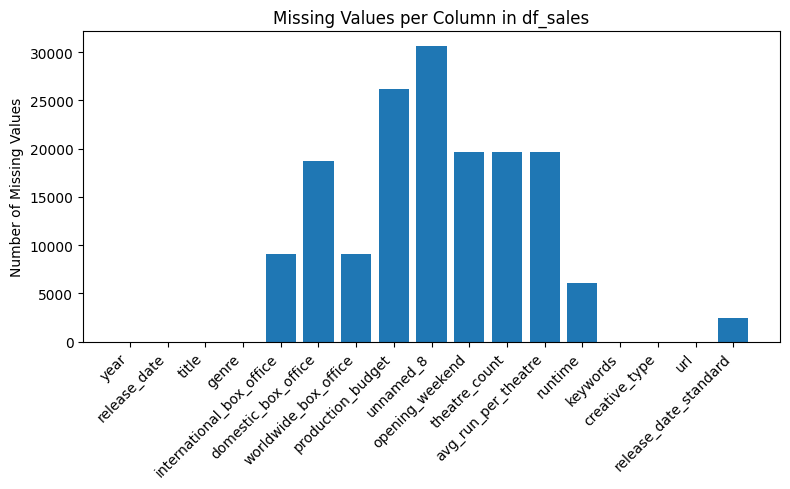

In [7]:
# Missing values for each column
missing_values = df_sales.isna().sum()

plt.figure(figsize=(8, 5))
plt.bar(missing_values.index, missing_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Column in df_sales")
plt.tight_layout()
plt.show()

**Data Quality Overview**

The dataset contains 30,612 rows and 16 columns. Several fields exhibit substantial missingness, which affects their analytical usefulness:
- production_budget: 26,132 missing entries
- domestic_box_office: 18,728 missing entries
- international_box_office: 9,037 missing entries
- unnamed_8: 30,612 missing entries (entire column missing)

These variables will require either imputation, removal, or external data enrichment depending on the analytical objectives.

Columns with High Usability
- Several key descriptive fields are fully complete:
- year, title, genre: 0 missing values

Other fields have moderate missingness but remain potentially usable with appropriate handling:
runtime: 6,053 missing values (≈20% of records)

In [9]:
display(df_sales.head())

,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,unnamed_8,opening_weekend,theatre_count,avg_run_per_theatre,runtime,keywords,creative_type,url,release_date_standard
0,2000,January 1st,bakha satang,drama,76576.0,NaN,76576.0,NaN,NaN,NaN,NaN,NaN,129.0,nan,contemporary fiction,https://www.the-numbers.com/movie/bakha-satang...,2000-01-01
1,2001,January 12th,antitrust,thriller/suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,2433.0,3.1,NaN,nan,contemporary fiction,https://www.the-numbers.com/movie/antitrust,2001-01-12
2,2000,January 28th,santitos,nan,NaN,378562.0,NaN,NaN,NaN,NaN,NaN,NaN,105.0,nan,nan,https://www.the-numbers.com/movie/santitos,2000-01-28
3,2002,2002 (Wide) by,frank mcklusky c.i.,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,https://www.the-numbers.com/movie/frank-mcklus...,NaN
4,2002,January 25th,a walk to remember,drama,4833792.0,41227069.0,46060861.0,11000000.0,NaN,12177488.0,2411.0,5.3,NaN,coming of age,contemporary fiction,https://www.the-numbers.com/movie/walk-to-reme...,2002-01-25


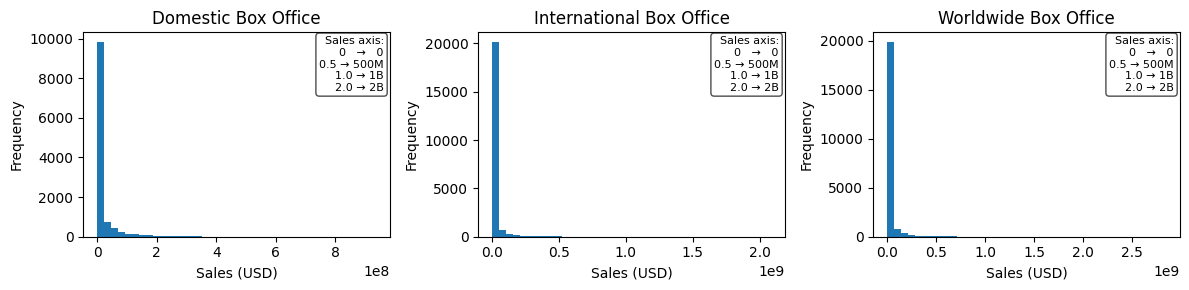

In [10]:
# Plot sales distributions
cols = ["domestic_box_office", "international_box_office", "worldwide_box_office"]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

notation = (
    "Sales axis:\n"
    "0   →   0\n"
    "0.5 → 500M\n"
    "1.0 → 1B\n"
    "2.0 → 2B"
)

for ax, col in zip(axes, cols):
    if col in df_sales.columns:
        _ = ax.hist(df_sales[col].dropna(), bins=40)
        _ = ax.set_title(col.replace("_", " ").title())
        _ = ax.set_xlabel("Sales (USD)")
        _ = ax.set_ylabel("Frequency")

        # suppress printed return value
        _ = ax.text(
            0.98, 0.98,
            notation,
            transform=ax.transAxes,
            fontsize=8,
            ha='right',
            va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
        )

plt.tight_layout()
plt.show()


**Interpretation of the Box Office Histograms**

The three histograms (Domestic, International, and Worldwide Box Office) show how movie revenues are distributed.
- The x-axis represents sales in USD, but very large values are shown in compressed scientific notation. The legend explains that values like 0.5, 1.0, 2.0 actually correspond to 500M, 1B, and 2B USD.
- The y-axis, labeled Frequency, indicates how many movies fall into each revenue range (bin). A higher bar means more movies in that sales interval.

Across all three charts, the very tall bar near zero shows that most movies earn very little revenue, while only a small number reach hundreds of millions or billions. This creates a long right tail, indicating that box office revenues are extremely skewed, with many low-earning films and a few very high-earning blockbusters.

/var/folders/f5/209y4jt56294rcfrj727k5gw0000gn/T/ipykernel_81844/1207661470.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/f5/209y4jt56294rcfrj727k5gw0000gn/T/ipykernel_81844/1207661470.py:23: UserWarning: 
The palette list has fewer values (4) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


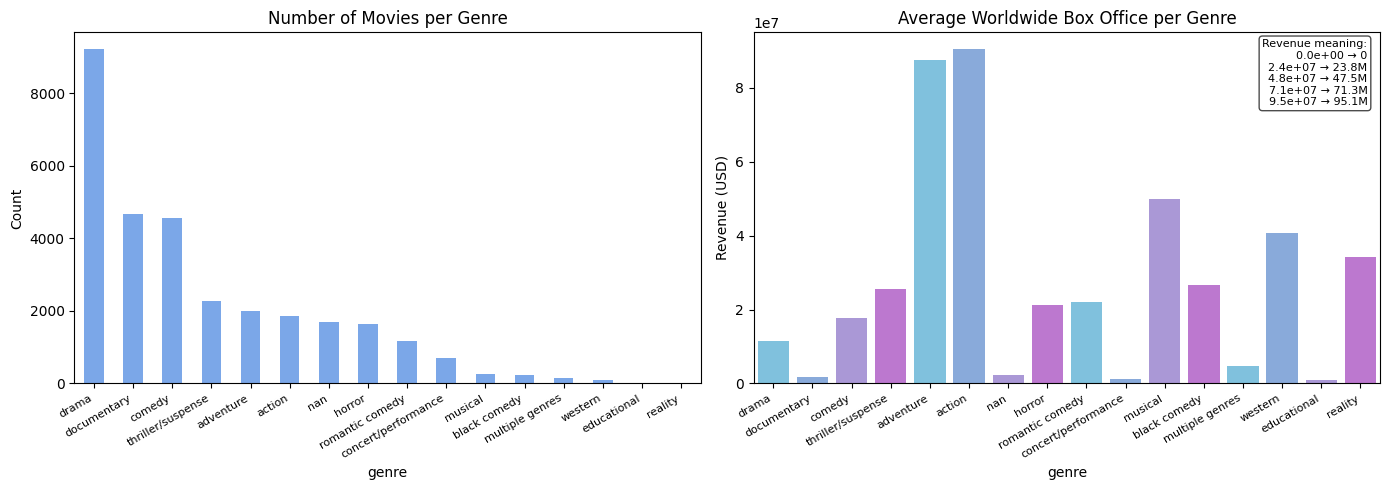

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_counts = df_sales['genre'].value_counts()  # number of movies per genre

# align sales to the same genre order as counts
genre_sales = (
    df_sales.groupby('genre')['worldwide_box_office']
    .mean()
    .reindex(genre_counts.index)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
palette = ["#71C7EC", "#7BA7E8", "#A68DE1", "#C46ADD"]

# genre counts 
genre_counts.plot(kind='bar', ax=axes[0], color="#7BA7E8")
axes[0].set_title("Number of Movies per Genre")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("genre")

# average sales per genre 
sns.barplot(
    x=genre_sales.index,
    y=genre_sales.values,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Average Worldwide Box Office per Genre")
axes[1].set_ylabel("Revenue (USD)")
axes[1].set_xlabel("genre")

# x-label formatting: rotate + right-align + smaller font
for ax in axes:
    ax.tick_params(axis='x', labelrotation=30, labelsize=8)
    for label in ax.get_xticklabels():
        label.set_ha('right')

# dynamic notation based on y-axis (
ymin, ymax = axes[1].get_ylim()

def human_format(num):
    if num >= 1_000_000_000:
        return f"{num/1e9:.1f}B"
    if num >= 1_000_000:
        return f"{num/1e6:.1f}M"
    return f"{num:.0f}"

notation = (
    "Revenue meaning:\n"
    f"{ymin:.1e} → {human_format(ymin)}\n"
    f"{(ymax*0.25):.1e} → {human_format(ymax*0.25)}\n"
    f"{(ymax*0.50):.1e} → {human_format(ymax*0.50)}\n"
    f"{(ymax*0.75):.1e} → {human_format(ymax*0.75)}\n"
    f"{ymax:.1e} → {human_format(ymax)}"
)

axes[1].text(
    0.98, 0.98,
    notation,
    transform=axes[1].transAxes,
    fontsize=8,
    ha='right',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()


Genre Summary: 

- Drama is the most produced genre, but earns low average revenue.
- Action and adventure earn the highest revenues (≈$90M+).
- Musical and reality have few films but high revenue.
- Documentary, drama, and educational genres show very low earnings.
- High production volume does not correlate with high revenue.

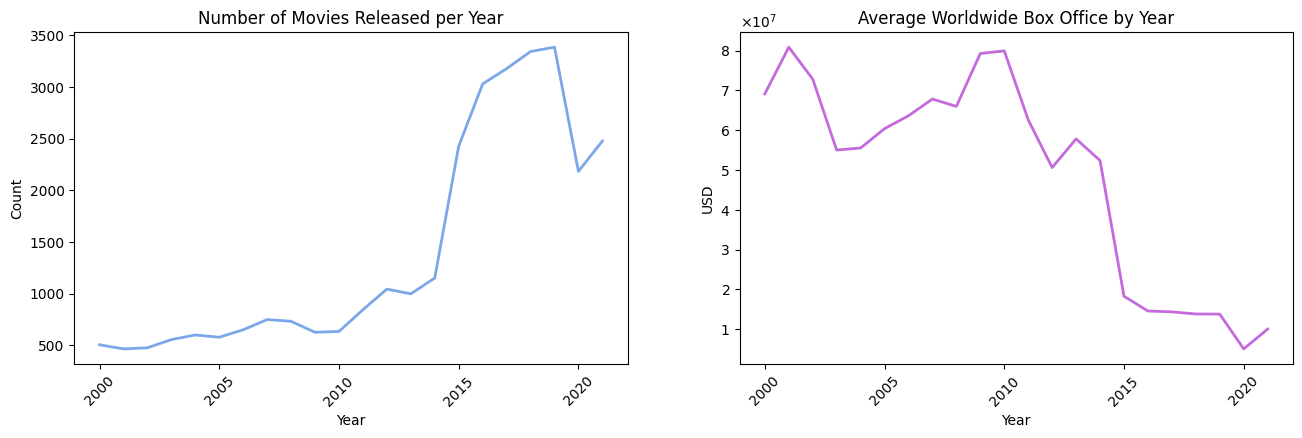

In [9]:
from matplotlib.ticker import ScalarFormatter

year_counts = df_sales['year'].value_counts().sort_index()
year_avg_sales = df_sales.groupby('year')['worldwide_box_office'].mean()

palette = ["#71C7EC", "#7BA7E8", "#A68DE1", "#C46ADD"]

# merged plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.tight_layout(pad=5)

# number of movies released per year
axes[0].plot(year_counts.index, year_counts.values, color=palette[1], linewidth=2)
axes[0].set_title("Number of Movies Released per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

# average worldwide box office per year
axes[1].plot(year_avg_sales.index, year_avg_sales.values, color=palette[3], linewidth=2)
axes[1].set_title("Average Worldwide Box Office by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("USD")
axes[1].tick_params(axis="x", rotation=45)

# notation
axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()


Yearly Trends:

- Movies released increased sharply from 2000 to 2018, peaking at ~3,400 films.
- Production dropped in 2019–2020, likely due to global disruptions.
- Average box office peaked around 2001 and 2010, then declined steadily after 2013.
- Recent years show many more movies but much lower revenue per film.

Yearly Trends:

- Movies released increased sharply from 2000 to 2018, peaking at ~3,400 films.
- Production dropped in 2019–2020, likely due to global disruptions.
- Average box office peaked around 2001 and 2010, then declined steadily after 2013.
- Recent years show many more movies but much lower revenue per film.

# 1.5 Data Integration (Iro)

1. Helper function 

Scope:

Define three utility functions to standardize key movie identifiers:
- extract_url_slug() → isolates the comparable part of each URL
- normalize_title() → cleans and standardizes movie titles
- make_movie_id() → generates a unique, stable movie identifier

A consistent system for matching movies across all datasets, even when URLs differ, titles vary, or remakes exist.

In [10]:
import re

# Extract last part of URL to use as slug
def extract_url_slug(url):
    if pd.isna(url):
        return np.nan
    url = str(url)
    url = url.split('?')[0].split('#')[0]
    slug = url.strip('/').split('/')[-1].lower()
    slug = re.sub(r'[^a-z0-9\-]+', '-', slug)
    slug = re.sub(r'-+', '-', slug).strip('-')
    return slug or np.nan

# Normalize title for matching
STOP_WORDS = {"the", "a", "an"}

def normalize_title(title):
    if pd.isna(title):
        return np.nan
    t = re.sub(r'[^\w\s]', ' ', str(title).lower())
    words = t.split()
    if words and words[0] in STOP_WORDS:
        words = words[1:]
    return " ".join(words) or np.nan

# movie_key + SERIAL MOVIE ID SYSTEM 

def build_movie_key(df: pd.DataFrame) -> pd.Series:
    """
    One logical key per movie: normalized_title + release_year.
    Same movie across datasets => same movie_key.
    """
    return (
        df["normalized_title"].fillna("").astype(str)
        + "||" +
        df["release_year"].fillna(0).astype(int).astype(str)
    )

serial_counter = {"count": 0}

def generate_serial_id():
    serial_counter["count"] += 1
    return f"MOV{serial_counter['count']:05d}"  # MOV00001, MOV00002, ...

def make_movie_id(movie_key):
    """
    Turn a movie_key into a serial movie_id.
    Called later in the master table, once per unique movie_key.
    """
    if pd.isna(movie_key) or movie_key == "":
        return np.nan
    return generate_serial_id()

2. Update Metaclean data

Scope:

Extract URL slug, normalize title, get release year, and assign movie_id for Metaclean movies.
Metaclean movies now have clean identifiers and are ready to join.

In [11]:
df_metaclean = df_metaclean.copy()

# URL slug
df_metaclean["url_slug"] = df_metaclean["url"].apply(extract_url_slug)

# Normalized title
df_metaclean["normalized_title"] = df_metaclean["title"].apply(normalize_title)

# Parse RelDate to datetime and extract year
df_metaclean["RelDate_parsed"] = pd.to_datetime(df_metaclean["RelDate"], errors="coerce")
df_metaclean["release_year"] = df_metaclean["RelDate_parsed"].dt.year

# NEW: movie_key (no movie_id yet)
df_metaclean["movie_key"] = build_movie_key(df_metaclean)

df_metaclean.head()


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,url_slug,normalized_title,RelDate_parsed,release_year,movie_key
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01,women-art-revolution,women art revolution,2011-06-01,2011,women art revolution||2011
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11,10-cloverfield-lane,10 cloverfield lane,2016-03-11,2016,10 cloverfield lane||2016
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,10-items-or-less,10 items or less,2006-12-01,2006,10 items or less||2006
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14,10-years,10 years,2012-09-14,2012,10 years||2012
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28,100-bloody-acres,100 bloody acres,2013-06-28,2013,100 bloody acres||2013


3. Update Sales 

Scope:

Extract URL slug, normalize title, use Sales year, and assign movie_id for Sales movies.

Sales data follows the same ID system and can be merged with Metaclean.

In [12]:
df_sales = df_sales.copy()

# URL slug
df_sales["url_slug"] = df_sales["url"].apply(extract_url_slug)

# Normalized title
df_sales["normalized_title"] = df_sales["title"].apply(normalize_title)

# Use 'year' column as release_year
df_sales["release_year"] = df_sales["year"]

# NEW: movie_key (no movie_id yet)
df_sales["movie_key"] = build_movie_key(df_sales)

df_sales.head()


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,unnamed_8,opening_weekend,...,avg_run_per_theatre,runtime,keywords,creative_type,url,release_date_standard,url_slug,normalized_title,release_year,movie_key
0,2000,January 1st,bakha satang,drama,76576.0,NaN,76576.0,NaN,NaN,NaN,...,NaN,129.0,nan,contemporary fiction,https://www.the-numbers.com/movie/bakha-satang...,2000-01-01,bakha-satang-s-korea,bakha satang,2000,bakha satang||2000
1,2001,January 12th,antitrust,thriller/suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,...,3.1,NaN,nan,contemporary fiction,https://www.the-numbers.com/movie/antitrust,2001-01-12,antitrust,antitrust,2001,antitrust||2001
2,2000,January 28th,santitos,nan,NaN,378562.0,NaN,NaN,NaN,NaN,...,NaN,105.0,nan,nan,https://www.the-numbers.com/movie/santitos,2000-01-28,santitos,santitos,2000,santitos||2000
3,2002,2002 (Wide) by,frank mcklusky c.i.,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nan,nan,https://www.the-numbers.com/movie/frank-mcklus...,NaN,frank-mcklusky-c-i,frank mcklusky c i,2002,frank mcklusky c i||2002
4,2002,January 25th,a walk to remember,drama,4833792.0,41227069.0,46060861.0,11000000.0,NaN,12177488.0,...,5.3,NaN,coming of age,contemporary fiction,https://www.the-numbers.com/movie/walk-to-reme...,2002-01-25,walk-to-remember-a,walk to remember,2002,walk to remember||2002


Now Sales has the same movie_key as Metaclean for the same title+year.

4. Build the master movie table

Scope:

Combine Metaclean and Sales movies, remove duplicates, and form one master list.

A unified movies_master table with one consistent movie_id per movie.

In [13]:
# Build the master movie table (with movie_key + source_label) 
# 1) Define desired columns from each dataset
meta_wanted = [
    "movie_key", "url", "url_slug", "title", "normalized_title",
    "release_year", "RelDate", "runtime", "studio", "genre", "director",
    "cast"
]

sales_wanted = [
    "movie_key", "url", "url_slug", "title", "normalized_title",
    "release_year", "release_date", "runtime", "genre", "studio"
]

# 2) Keep only existing columns
meta_cols = [c for c in meta_wanted if c in df_metaclean.columns]
sales_cols = [c for c in sales_wanted if c in df_sales.columns]

# 3) Build movie tables with source labels
meta_movies = df_metaclean[meta_cols].copy()
meta_movies["source_label"] = "metaclean"

sales_movies = df_sales[sales_cols].copy()
sales_movies["source_label"] = "sales"

# 4) Combine the two
movies_all = pd.concat([meta_movies, sales_movies], ignore_index=True)

# 5) One row per unique movie_key
movies_master = (
    movies_all
    .drop_duplicates(subset=["movie_key"], keep="first")
    .reset_index(drop=True)
)

# 6) NOW create the serial movie_id once per movie_key
movies_master["movie_id"] = movies_master["movie_key"].apply(make_movie_id)

movies_master.head()


,movie_key,url,url_slug,title,normalized_title,release_year,RelDate,runtime,studio,genre,director,cast,source_label,release_date,movie_id
0,women art revolution||2011,https://www.metacritic.com/movie/!women-art-re...,women-art-revolution,!Women Art Revolution,women art revolution,2011,2011-06-01,83.0,Hotwire Productions,Documentary,Lynn Hershman-Leeson,NaN,metaclean,NaN,MOV00001
1,10 cloverfield lane||2016,https://www.metacritic.com/movie/10-cloverfiel...,10-cloverfield-lane,10 Cloverfield Lane,10 cloverfield lane,2016,2016-03-11,104.0,Paramount Pictures,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",Dan Trachtenberg,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",metaclean,NaN,MOV00002
2,10 items or less||2006,https://www.metacritic.com/movie/10-items-or-less,10-items-or-less,10 Items or Less,10 items or less,2006,2006-12-01,82.0,Click Star,"Drama,Comedy,Romance",Brad Silberling,"Jonah Hill,Morgan Freeman,Paz Vega",metaclean,NaN,MOV00003
3,10 years||2012,https://www.metacritic.com/movie/10-years,10-years,10 Years,10 years,2012,2012-09-14,100.0,Anchor Bay Entertainment,"Drama,Comedy,Romance",Jamie Linden,"Channing Tatum,Chris Pratt,Jenna Dewan",metaclean,NaN,MOV00004
4,100 bloody acres||2013,https://www.metacritic.com/movie/100-bloody-acres,100-bloody-acres,100 Bloody Acres,100 bloody acres,2013,2013-06-28,91.0,Music Box Films,"Horror,Comedy",Cameron Cairnes,NaN,metaclean,NaN,MOV00005


Short Explanation of Key Metadata: 
- movie_id
    A unique serial code that identifies each movie across all datasets.
- url_slug
    A cleaned identifier extracted from the movie’s URL, used to match movies between Metacritic and Sales data.
- normalized_title
    A standardized version of the title (lowercase, punctuation removed, stop-words removed) to help detect duplicates and remakes.
- release_year
    Used to distinguish movies with the same title (different versions or remakes).
- RelDate
    Release date from Metacritic — the editorial/critic-side reference date.
- source_label
    Indicates where the row came from (metaclean or sales), allowing comparison of editorial metadata vs financial metadata.
    cast

Overall, this table combines movie information from different sources into one clean reference framework, enabling reliable linking of reviews, box office data, and metadata through a consistent movie_id.

In [14]:
# Attach movie_id back to original tables (PK→FK)
df_metaclean = df_metaclean.merge(
    movies_master[["movie_key", "movie_id"]],
    on="movie_key",
    how="left"
)

df_sales = df_sales.merge(
    movies_master[["movie_key", "movie_id"]],
    on="movie_key",
    how="left"
)


Now the same movie (same title + year) has the same movie_id in:
movies_master
df_metaclean
df_sales

5. Attach movie_id to Expert reviews 

Scope:

Match reviews to movies using URL slug, then add movie_id.

All expert reviews are linked to the correct movie entry.

In [15]:
df_exreviews = df_exreviews.copy()

# URL slug
df_exreviews["url_slug"] = df_exreviews["url"].apply(extract_url_slug)

# Merge on url_slug -> movie_id
df_exreviews = df_exreviews.merge(
    movies_master[["movie_id", "url_slug"]],
    on="url_slug",
    how="left",
    suffixes=("", "_movie")
)

df_exreviews.head()


,url,idvscore,reviewer,dateP,Rev,url_slug,movie_id
0,https://www.metacritic.com/movie/bronson,100.0,"""Andrew O'Hehir""",None,'Bronson owes a little or a lot to Kubrick s ...,bronson,MOV01565
1,https://www.metacritic.com/movie/bronson,90.0,'A.O. Scott',None,'Bronson invites you to admire its protagonis...,bronson,MOV01565
2,https://www.metacritic.com/movie/bronson,90.0,None,None,'Whether it s Peterson/Bronson s more theatri...,bronson,MOV01565
3,https://www.metacritic.com/movie/bronson,83.0,'Noel Murray',None,'There are two Bronsons on display here: the ...,bronson,MOV01565
4,https://www.metacritic.com/movie/bronson,80.0,'Joshua Rothkopf',None,'Refn has somehow found his way to an authent...,bronson,MOV01565


6. Attach movie_id to User reviews 

Scope:

Match user reviews to movies using URL slug, then add movie_id.

All user reviews are now connected to the right movie.

In [16]:
df_usreviews = df_usreviews.copy()

# URL slug
df_usreviews["url_slug"] = df_usreviews["url"].apply(extract_url_slug)

# Merge on url_slug -> movie_id
df_usreviews = df_usreviews.merge(
    movies_master[["movie_id", "url_slug"]],
    on="url_slug",
    how="left",
    suffixes=("", "_movie")
)

df_usreviews.head()


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot,url_slug,movie_id
0,https://www.metacritic.com/movie/bronson,8,'Longbottom94',"'Apr 25, 2013'",'Many have dismissed this film for not explor...,2,2,bronson,MOV01565
1,https://www.metacritic.com/movie/bronson,9,'MartinB',"'Oct 13, 2009'",'Anyone who doesn t like this movie simply ju...,0,1,bronson,MOV01565
2,https://www.metacritic.com/movie/bronson,10,'Jaakko',"'Jul 19, 2012'",'Not sure what to think at this film at first...,1,1,bronson,MOV01565
3,https://www.metacritic.com/movie/bronson,6,'CapoR',"'Oct 13, 2009'",'Nicely portrayed but it lacks the elements t...,0,1,bronson,MOV01565
4,https://www.metacritic.com/movie/bronson,8,'OrwellB.',"'Oct 10, 2009'",'Bronson is more than entertainment. It is ar...,0,0,bronson,MOV01565


**For dateP, we already have changed from 1.2 and 1.3. the date format , so double check if it works **

---------------test the output with a remake of a movie --------------------------

In [17]:
# titles that appear in more than one release_year
remake_counts = (
    movies_master
    .groupby("normalized_title")["release_year"]
    .nunique()
)

remake_titles = remake_counts[remake_counts > 1]
remake_titles.head()


normalized_title
100 streets    2
11th hour      2
13 minutes     2
17 blocks      2
1921           2
Name: release_year, dtype: int64

In [18]:
# Sales summary (one row per movie_id)
sales_main = (
    df_sales
    .drop_duplicates(subset=["movie_id"])
    [["movie_id", "year", "domestic_box_office",
      "international_box_office", "worldwide_box_office"]]
)

#Expert review summary (ensure numeric)
exp_tmp = df_exreviews.copy()
exp_tmp["idvscore"] = pd.to_numeric(exp_tmp["idvscore"], errors="coerce")

exp_summary = (
    exp_tmp
    .groupby("movie_id", as_index=False)
    .agg(
        n_expert_reviews=("idvscore", "count"),
        avg_expert_score=("idvscore", "mean")
    )
)

# User review summary (ensure numeric)
usr_tmp = df_usreviews.copy()
usr_tmp["idvscore"] = pd.to_numeric(usr_tmp["idvscore"], errors="coerce")

usr_summary = (
    usr_tmp
    .groupby("movie_id", as_index=False)
    .agg(
        n_user_reviews=("idvscore", "count"),
        avg_user_score=("idvscore", "mean")
    )
)

# Merge everything with movies_master
movie_panel = (
    movies_master
    .merge(sales_main, on="movie_id", how="left")
    .merge(exp_summary, on="movie_id", how="left")
    .merge(usr_summary, on="movie_id", how="left")
)


In [19]:
some_title = "100 streets"  # duplicated movie


In [20]:
remake_example = movie_panel.loc[
    movie_panel["normalized_title"] == some_title,
][[
    "movie_id",
    "url",
    "url_slug",
    "title",
    "release_year",
    "RelDate",
    "source_label",
    "year",                    # sales year
    "domestic_box_office",
    "international_box_office",
    "worldwide_box_office",
    "n_expert_reviews",
    "avg_expert_score",
    "n_user_reviews",
    "avg_user_score"
]]

remake_example


,movie_id,url,url_slug,title,release_year,RelDate,source_label,year,domestic_box_office,international_box_office,worldwide_box_office,n_expert_reviews,avg_expert_score,n_user_reviews,avg_user_score
5,MOV00006,https://www.metacritic.com/movie/100-streets,100-streets,100 Streets,2017,2017-01-13,metaclean,NaN,NaN,NaN,NaN,12.0,47.916667,0.0,NaN
13207,MOV13208,https://www.the-numbers.com/movie/100-streets-...,100-streets-uk,100 streets,2016,NaT,sales,2016.0,NaN,307.0,307.0,NaN,NaN,NaN,NaN


This is the merged table, we can join also other cells from other tables

Fully merges table 

In [21]:
# 1) CLEAN SALES (drop unwanted columns, one row per movie_id)
sales_main = (
    df_sales
    .drop(
        columns=[
            "genre",
            "avg_run_per_theater",
            "runtime",
            "keyword"
        ],
        errors="ignore"
    )
    .sort_values(["movie_id", "year"])
    .drop_duplicates(subset=["movie_id"], keep="last")
)

# ------------------------------------------------------------
# 2) EXPERT REVIEWS SUMMARY
exp_summary = (
    df_exreviews
    .assign(idvscore=pd.to_numeric(df_exreviews["idvscore"], errors="coerce"))
    .groupby("movie_id", as_index=False)
    .agg(
        n_expert_reviews=("idvscore", "count"),
        avg_expert_score=("idvscore", "mean")
    )
)

# ------------------------------------------------------------
# 3) USER REVIEWS SUMMARY (drop thumbs + tot)
usr_summary = (
    df_usreviews
    .drop(columns=["thumbs_up", "tot"], errors="ignore")
    .assign(idvscore=pd.to_numeric(df_usreviews["idvscore"], errors="coerce"))
    .groupby("movie_id", as_index=False)
    .agg(
        n_user_reviews=("idvscore", "count"),
        avg_user_score=("idvscore", "mean")
    )
)

# ------------------------------------------------------------
# 4) MOVIE MASTER (drop runtime from metaclean side)
movies_master_clean = (
    movies_master
    .drop(columns=["runtime"], errors="ignore")
)

# ------------------------------------------------------------
# 5) FULLY MERGED PANEL (ONE ROW PER MOVIE_ID)
movie_panel_full = (
    movies_master_clean
    .merge(sales_main,  on="movie_id", how="left", validate="1:1")
    .merge(exp_summary, on="movie_id", how="left", validate="1:1")
    .merge(usr_summary, on="movie_id", how="left", validate="1:1")
)

movie_panel_full

,movie_key_x,url_x,url_slug_x,title_x,normalized_title_x,release_year_x,RelDate,studio,genre,director,...,url_y,release_date_standard,url_slug_y,normalized_title_y,release_year_y,movie_key_y,n_expert_reviews,avg_expert_score,n_user_reviews,avg_user_score
0,women art revolution||2011,https://www.metacritic.com/movie/!women-art-re...,women-art-revolution,!Women Art Revolution,women art revolution,2011,2011-06-01,Hotwire Productions,Documentary,Lynn Hershman-Leeson,...,https://www.the-numbers.com/movie/women-art-re...,2011-06-01,women-art-revolution,women art revolution,2011.0,women art revolution||2011,11.0,70.090909,0.0,NaN
1,10 cloverfield lane||2016,https://www.metacritic.com/movie/10-cloverfiel...,10-cloverfield-lane,10 Cloverfield Lane,10 cloverfield lane,2016,2016-03-11,Paramount Pictures,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",Dan Trachtenberg,...,https://www.the-numbers.com/movie/10-cloverfie...,2016-03-11,10-cloverfield-lane,10 cloverfield lane,2016.0,10 cloverfield lane||2016,43.0,75.744186,201.0,7.303483
2,10 items or less||2006,https://www.metacritic.com/movie/10-items-or-less,10-items-or-less,10 Items or Less,10 items or less,2006,2006-12-01,Click Star,"Drama,Comedy,Romance",Brad Silberling,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,58.200000,9.0,6.000000
3,10 years||2012,https://www.metacritic.com/movie/10-years,10-years,10 Years,10 years,2012,2012-09-14,Anchor Bay Entertainment,"Drama,Comedy,Romance",Jamie Linden,...,https://www.the-numbers.com/movie/10-years,2012-09-14,10-years,10 years,2012.0,10 years||2012,18.0,62.666667,7.0,6.142857
4,100 bloody acres||2013,https://www.metacritic.com/movie/100-bloody-acres,100-bloody-acres,100 Bloody Acres,100 bloody acres,2013,2013-06-28,Music Box Films,"Horror,Comedy",Cameron Cairnes,...,https://www.the-numbers.com/movie/100-bloody-a...,2013-06-28,100-bloody-acres,100 bloody acres,2013.0,100 bloody acres||2013,10.0,65.800000,2.0,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33767,octonauts the ring of fire||2021,https://www.the-numbers.com/movie/octonauts-th...,octonauts-the-ring-of-fire-2021-china,octonauts: the ring of fire,octonauts the ring of fire,2021,NaT,NaN,adventure,NaN,...,https://www.the-numbers.com/movie/octonauts-th...,2021-01-01,octonauts-the-ring-of-fire-2021-china,octonauts the ring of fire,2021.0,octonauts the ring of fire||2021,NaN,NaN,NaN,NaN
33768,sing me a song||2021,https://www.the-numbers.com/movie/sing-me-a-so...,sing-me-a-song-france,sing me a song,sing me a song,2021,NaT,NaN,documentary,NaN,...,https://www.the-numbers.com/movie/sing-me-a-so...,2021-01-01,sing-me-a-song-france,sing me a song,2021.0,sing me a song||2021,NaN,NaN,NaN,NaN
33769,jokbeoldu sinmun iyagi||2021,https://www.the-numbers.com/movie/jokbeoldu-si...,jokbeoldu-sinmun-iyagi-2020-south-korea,jokbeoldu sinmun iyagi,jokbeoldu sinmun iyagi,2021,NaT,NaN,documentary,NaN,...,https://www.the-numbers.com/movie/jokbeoldu-si...,2021-01-01,jokbeoldu-sinmun-iyagi-2020-south-korea,jokbeoldu sinmun iyagi,2021.0,jokbeoldu sinmun iyagi||2021,NaN,NaN,NaN,NaN
33770,escort vehicle 36||2021,https://www.the-numbers.com/movie/escort-vehic...,escort-vehicle-36-2020-china,escort vehicle 36,escort vehicle 36,2021,NaT,NaN,action,NaN,...,https://www.the-numbers.com/movie/escort-vehic...,2021-01-01,escort-vehicle-36-2020-china,escort vehicle 36,2021.0,escort vehicle 36||2021,NaN,NaN,NaN,NaN


Final table is a movie-level panel:
- One row = one movie (movie_id)
- Reviews = statistics, not observations

# 1.6 Database normalization

Genre / Actor / Cast Table Creation and Unique IDs (Iro)

In [22]:
# Normalization helpers (put in a new cell after movie_panel)

def split_list_string(s):
    """
    Generic splitter for columns like 'genre' and 'cast'.
    Tries to handle common separators: ',', '/', '|', ';'
    Returns a clean list of non-empty strings.
    """
    if pd.isna(s):
        return []
    parts = re.split(r'[|/;,]', str(s))
    return [p.strip() for p in parts if p and p.strip()]

Genre table: One row per (movie_id, genre), separate serial genre_id


In [23]:
# Start from movies_master, which already has one row per movie_id
genre_rows = (
    movies_master[["movie_id", "genre"]]
    .dropna(subset=["genre"])                           # keep rows that have a genre
    .assign(genre_list=lambda df: df["genre"].apply(split_list_string))
    .explode("genre_list")                              # one row per movie_id–genre
    .rename(columns={"genre_list": "genre_name"})
)

# Clean and deduplicate
genre_rows["genre_name"] = genre_rows["genre_name"].str.strip()
genre_rows = genre_rows[genre_rows["genre_name"] != ""]
genre_rows = genre_rows.drop_duplicates(subset=["movie_id", "genre_name"]).reset_index(drop=True)

# Add serial genre_id (PK for this table)
genre_rows["genre_id"] = [
    f"GEN{idx:05d}" for idx in range(1, len(genre_rows) + 1)
]

# Final Genre table (as per your spec)
genre_table = genre_rows[["genre_id", "movie_id", "genre_name"]]

genre_table.head()

,genre_id,movie_id,genre_name
0,GEN00001,MOV00001,Documentary
1,GEN00002,MOV00002,Action
2,GEN00003,MOV00002,Sci-Fi
3,GEN00004,MOV00002,Drama
4,GEN00005,MOV00002,Mystery


Actor + Cast tables: 
Actor Table: one row per actor name, separate serial actor_id
Cast Table: relationship table linking actor_id ↔ movie_id (using cast strings)

In [24]:
# Explode the cast column at movie level
cast_exploded = (
    movies_master[["movie_id", "cast"]]
    .dropna(subset=["cast"])                               # keep rows with cast info
    .assign(actor_list=lambda df: df["cast"].apply(split_list_string))
    .explode("actor_list")
    .rename(columns={"actor_list": "actor_name"})
)

# Clean actor names
cast_exploded["actor_name"] = cast_exploded["actor_name"].str.strip()
cast_exploded = cast_exploded[cast_exploded["actor_name"] != ""]
cast_exploded = cast_exploded.drop_duplicates(subset=["movie_id", "actor_name"]).reset_index(drop=True)

# Build ACTOR TABLE (dimension)
actors = (
    cast_exploded[["actor_name"]]
    .drop_duplicates()
    .sort_values("actor_name")
    .reset_index(drop=True)
)

actors["actor_id"] = [
    f"ACT{idx:05d}" for idx in range(1, len(actors) + 1)
]

actor_table = actors[["actor_id", "actor_name"]]

# Build CAST TABLE (linking actor_id <-> movie_id)
cast_table = (
    cast_exploded
    .merge(actor_table, on="actor_name", how="left")
    [["actor_id", "movie_id"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

actor_table.head(), cast_table.head()

(   actor_id         actor_name
 0  ACT00001            50 Cent
 1  ACT00002            6ix9ine
 2  ACT00003         A Martinez
 3  ACT00004   A. Brian Daniels
 4  ACT00005  A. Patrice Moreau,
    actor_id  movie_id
 0  ACT11712  MOV00002
 1  ACT11720  MOV00002
 2  ACT16010  MOV00002
 3  ACT11927  MOV00003
 4  ACT17396  MOV00003)

In [ ]:
# Sort for reproducibility of the IDs (optional but a good idea)
df_sales = df_sales.sort_values(["movie_id", "release_date"]).reset_index(drop=True)

df_sales["sale_id"] = [
    f"SAL{idx:06d}" for idx in range(1, len(df_sales) + 1)
]

df_sales.head()

,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,Unnamed: 8,opening_weekend,...,runtime,keywords,creative_type,url,url_slug,normalized_title,release_year,movie_key,movie_id,sale_id
0,2011,June 1st,"!Women, Art, Revolution",Documentary,NaN,52681.0,NaN,NaN,NaN,5791.0,...,83.0,Artists,Factual,https://www.the-numbers.com/movie/Women-Art-Re...,women-art-revolution,women art revolution,2011,women art revolution||2011,MOV00001,SAL000001
1,2016,March 11th,10 Cloverfield Lane,Thriller/Suspense,36203423.0,72082999.0,108286422.0,15000000.0,NaN,24727437.0,...,103.0,Kidnap,Contemporary Fiction,https://www.the-numbers.com/movie/10-Cloverfie...,10-cloverfield-lane,10 cloverfield lane,2016,10 cloverfield lane||2016,MOV00002,SAL000002
2,2012,September 14th,10 Years,Drama,783986.0,203654.0,987640.0,NaN,NaN,22707.0,...,100.0,Ensemble,Contemporary Fiction,https://www.the-numbers.com/movie/10-Years,10-years,10 years,2012,10 years||2012,MOV00004,SAL000003
3,2013,June 28th,100 Bloody Acres,Black Comedy,NaN,6388.0,NaN,NaN,NaN,3419.0,...,91.0,Accidental Death,Contemporary Fiction,https://www.the-numbers.com/movie/100-Bloody-A...,100-bloody-acres,100 bloody acres,2013,100 bloody acres||2013,MOV00005,SAL000004
4,2015,July 10th,"10,000 KM",Drama,20452.0,NaN,20452.0,NaN,NaN,NaN,...,98.0,Romance,Contemporary Fiction,https://www.the-numbers.com/movie/10000-KM,10000-km,10 000 km,2015,10 000 km||2015,MOV00009,SAL000005


In [ ]:
df_exreviews.columns

Index(['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'url_slug', 'movie_id'], dtype='object')

In [25]:
#  REVIEW_ID on Expert reviews 

# auto-detect a date column if one exists
date_candidates = ["datep_clean", "datep", "dateP", "date", "review_date", "pubdate", "pub_date"]
date_col = None
for c in date_candidates:
    if c in df_exreviews.columns:
        date_col = c
        break

# Always sort at least by movie_id, and by date if available
sort_cols = ["movie_id"]
if date_col is not None:
    sort_cols.append(date_col)

df_exreviews = df_exreviews.sort_values(sort_cols).reset_index(drop=True)

# Create/overwrite expert_review_id
df_exreviews["expert_review_id"] = [
    f"EXR{idx:07d}" for idx in range(1, len(df_exreviews) + 1)
]

df_exreviews.head()


,url,idvscore,reviewer,dateP,Rev,url_slug,movie_id,expert_review_id
0,https://www.metacritic.com/movie/!women-art-re...,75.0,None,"'Aug 25, 2011'","'Fortunately, !Woman Art Revolution isn t a s...",women-art-revolution,MOV00001,EXR0000001
1,https://www.metacritic.com/movie/!women-art-re...,80.0,'Kevin Thomas',"'Jun 16, 2011'",'In her vibrant !Women Art Revolution Hershma...,women-art-revolution,MOV00001,EXR0000002
2,https://www.metacritic.com/movie/!women-art-re...,75.0,None,"'Jun 16, 2011'","'It s affecting, and the tone, which is polem...",women-art-revolution,MOV00001,EXR0000003
3,https://www.metacritic.com/movie/!women-art-re...,63.0,'Mike Scott',"'Jun 17, 2011'",'These women deserve to have their voices hea...,women-art-revolution,MOV00001,EXR0000004
4,https://www.metacritic.com/movie/!women-art-re...,90.0,'Rachel Saltz',"'Jun 2, 2011'",'These interviews form the backbone of !W.A.R...,women-art-revolution,MOV00001,EXR0000005


In [ ]:
df_usreviews.columns

In [26]:
# REVIEW_ID on User reviews 

date_candidates = ["datep", "dateP", "date", "review_date", "pubdate", "pub_date"]
date_col = None
for c in date_candidates:
    if c in df_usreviews.columns:
        date_col = c
        break

sort_cols = ["movie_id"]
if date_col is not None:
    sort_cols.append(date_col)

df_usreviews = df_usreviews.sort_values(sort_cols).reset_index(drop=True)

df_usreviews["user_review_id"] = [
    f"USR{idx:07d}" for idx in range(1, len(df_usreviews) + 1)
]

df_usreviews.head()

,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot,url_slug,movie_id,user_review_id
0,https://www.metacritic.com/movie/!women-art-re...,NaN,NaN,NaN,NaN,NaN,NaN,women-art-revolution,MOV00001,USR0000001
1,https://www.metacritic.com/movie/10-cloverfiel...,8,'Filmcritic1956',"'Apr 1, 2016'","'Ending was bad, switched genres. First 90% -...",5,6,10-cloverfield-lane,MOV00002,USR0000002
2,https://www.metacritic.com/movie/10-cloverfiel...,8,'cjm868',"'Apr 1, 2016'",'What a fantastic movie! 10 Cloverfield Lane ...,3,4,10-cloverfield-lane,MOV00002,USR0000003
3,https://www.metacritic.com/movie/10-cloverfiel...,8,'Unladenswallow0',"'Apr 1, 2016'",'If you like the flintstones and you likes cl...,2,3,10-cloverfield-lane,MOV00002,USR0000004
4,https://www.metacritic.com/movie/10-cloverfiel...,4,'jez1968',"'Apr 1, 2016'",'Good tension and build up for the first 90 m...,3,13,10-cloverfield-lane,MOV00002,USR0000005


In [ ]:
#movies_master.head()
#df_sales.head()
#genre_table.head()
#actor_table.head()
#cast_table.head()


# 1.7. Outlier Detection (Iro)

In [ ]:
for col in sales_cols:
    neg = (df_sales[col] < 0).sum()
    zero = (df_sales[col] == 0).sum()
    print(f"{col}: negative={neg}, zeros={zero}")

year: negative=0, zeros=0
international_box_office: negative=0, zeros=0
domestic_box_office: negative=0, zeros=0
worldwide_box_office: negative=0, zeros=0
production_budget: negative=0, zeros=0
Unnamed: 8: negative=0, zeros=0
opening_weekend: negative=0, zeros=0
theatre_count: negative=0, zeros=0
avg run per theatre: negative=0, zeros=17
runtime: negative=0, zeros=0
release_year: negative=0, zeros=0


So, there are no outliers 

# 1.8. Distribution plots 

In [27]:
def plot_numeric_distributions(df, title="Distribution of Numeric Columns", n_cols=3):
    
    # Select numeric columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove unnamed columns
    num_cols = [col for col in num_cols if not col.lower().startswith("unnamed")]
    
    # Remove constant-value columns (no real distribution)
    num_cols = [col for col in num_cols if df[col].nunique() > 1]
    
    if len(num_cols) == 0:
        print("No numeric columns left to plot.")
        return
    
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    
    plt.figure(figsize=(9, 2.2 * n_rows))  # compact layout
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=20)
        plt.title(col, fontsize=9, ha="center")
        plt.xlabel("")
        plt.ylabel("")
    
    plt.suptitle(title, fontsize=12, y=1.02, ha="center")
    plt.tight_layout(pad=1.0)
    plt.show()


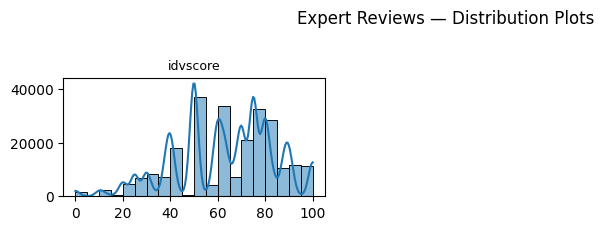

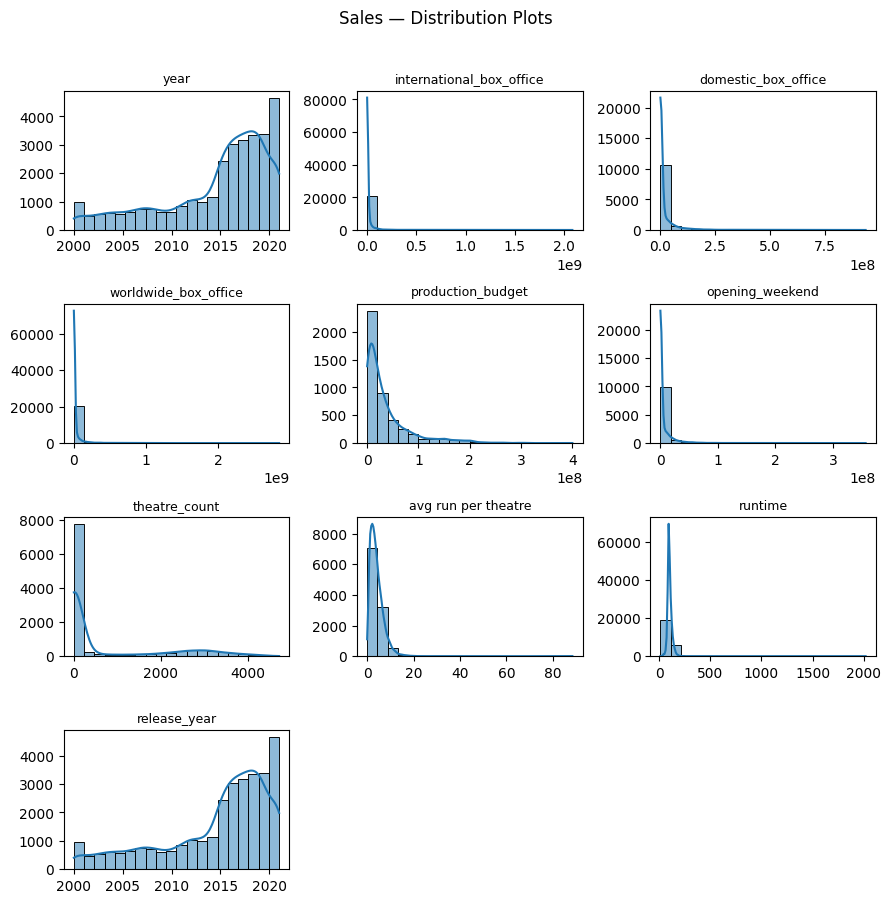

In [ ]:
plot_numeric_distributions(df_exreviews, title="Expert Reviews — Distribution Plots")
plot_numeric_distributions(df_sales, title="Sales — Distribution Plots")

For user reviews there are no numeric values to plot.

# Chapter 2 Feature Engineering
## 2.1 Correlation Analysis

Create a new dataframe (not overwrittinging) like:
X_movies  (one row per movie_id)


Existing normalized sources / relational tables:
- movies_master
- movie_panel_full
- df_exreviews
- df_usreviews
- genre_table
- actor_table
- cast_table
- df_sales

What a model actually needs
- X (features)  →  fixed-size numeric matrix
- y (target)    →  one label per row

Even movie_panel_full:
has strings
has NaNs
has no embeddings
has no dimensionality reduction
mixes storage and features

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Apply column removals

In [29]:
# ------------------------------------------------------------
# Create clean feature-engineering base table
movie_fe_base = (
    movie_panel_full
    # unify column name
    .rename(columns={
        "release_year_x": "release_year"
    })
    # drop all non-feature, duplicate, or forbidden columns
    .drop(
        columns=[
            # merge artifacts / duplicates
            "movie_key_x", "movie_key_y",
            "url_x", "url_y",
            "url_slug_x", "url_slug_y",
            "title_x", "title_y",
            "normalized_title_x", "normalized_title_y",
            "release_year_y",
            "release_date_x", "release_date_y",
            "release_date_standard",
            "source_label",
            "unnamed_8",
            "keywords",

            # metadata not used for ML
            "RelDate",
            "genre",
            "cast",
            "creative_type",

            # duplicated or forbidden numeric fields
            "year",
            "avg_run_per_theatre",
            "runtime"
        ],
        errors="ignore"
    )
)


In [30]:
df_usreviews = df_usreviews.drop(
    columns=["thumbs_up", "thumbsTot"],
    errors="ignore"
)

In [31]:
df_sales = df_sales.drop(
    columns=[
        "genre",
        "avg_run_per_theatre",
        "runtime",
        "keyword"
    ],
    errors="ignore"
)

In [32]:
movie_fe_base.head(5)

,release_year,studio,director,movie_id,international_box_office,domestic_box_office,worldwide_box_office,production_budget,opening_weekend,theatre_count,n_expert_reviews,avg_expert_score,n_user_reviews,avg_user_score
0,2011,Hotwire Productions,Lynn Hershman-Leeson,MOV00001,NaN,52681.0,NaN,NaN,5791.0,2.0,11.0,70.090909,0.0,NaN
1,2016,Paramount Pictures,Dan Trachtenberg,MOV00002,36203423.0,72082999.0,108286422.0,15000000.0,24727437.0,3391.0,43.0,75.744186,201.0,7.303483
2,2006,Click Star,Brad Silberling,MOV00003,NaN,NaN,NaN,NaN,NaN,NaN,20.0,58.200000,9.0,6.000000
3,2012,Anchor Bay Entertainment,Jamie Linden,MOV00004,783986.0,203654.0,987640.0,NaN,22707.0,3.0,18.0,62.666667,7.0,6.142857
4,2013,Music Box Films,Cameron Cairnes,MOV00005,NaN,6388.0,NaN,NaN,3419.0,13.0,10.0,65.800000,2.0,7.500000


Transformers - BERT embeddings via Hugging Face transformers

In [33]:
!pip install transformers sentence-transformers


In [34]:
import torch
from transformers import AutoTokenizer, AutoModel

/opt/anaconda3/envs/Python312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load bert 

In [35]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Encode texts (batching)


In [36]:
def bert_embed_texts(texts, tokenizer, model, batch_size=32, max_length=256, pooling="cls"):
    all_vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            out = model(**enc)  # last_hidden_state: [B, T, H]
            last_hidden = out.last_hidden_state

            if pooling == "cls":
                vecs = last_hidden[:, 0, :]  # [CLS]
            elif pooling == "mean":
                mask = enc["attention_mask"].unsqueeze(-1)  # [B, T, 1]
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                vecs = summed / counts
            else:
                raise ValueError("pooling must be 'cls' or 'mean'")

            all_vecs.append(vecs.cpu().numpy())

    return np.vstack(all_vecs)


Apply to review text and aggregate to movie level

In [37]:
!pip install transformers sentence-transformers


Use BERT / Sentence-BERT transformers to convert raw review text into dense numeric feature vectors

Raw reviews

   ↓

Cleaning (done earlier)

   ↓

TRANSFORMER EMBEDDINGS   ← scope of transformers code

   ↓


Aggregate by movie_id

   ↓
F
eature selection (PCA / SVD)

   ↓

Final ML feature matrix

   ↓

Models

In [42]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [41]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# 1) Keep your existing preprocessing (good)
review_text_df = (
    df_exreviews[["movie_id", "Rev"]]
    .dropna(subset=["Rev"])
    .reset_index(drop=True)
)

texts = (
    review_text_df["Rev"]
    .astype(str)
    .str.slice(0, 500)   # truncate for speed
    .tolist()
)

# 2) FAST Hugging Face model (BERT-derived)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 3) Encode MUCH faster
emb = model.encode(
    texts,
    batch_size=128,          # ↑ big batch = speed
    show_progress_bar=True,
    convert_to_numpy=True
)

# 4) Build embedding dataframe
emb_cols = [f"emb_{i}" for i in range(emb.shape[1])]
review_emb_df = pd.DataFrame(emb, columns=emb_cols)
review_emb_df["movie_id"] = review_text_df["movie_id"].values

# 5) Aggregate to movie level (unchanged)
movie_emb_df = (
    review_emb_df
    .groupby("movie_id")[emb_cols]
    .mean()
    .reset_index()
)

# 6) Merge into feature base
X_with_emb = movie_fe_base.merge(movie_emb_df, on="movie_id", how="left")
X_with_emb[emb_cols] = X_with_emb[emb_cols].fillna(0.0)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Batches: 100%|██████████| 1929/1929 [04:33<00:00,  7.05it/s]


We used a pre-trained transformer model from the Hugging Face repository to extract dense semantic embeddings from expert review text. Review-level embeddings were aggregated at the movie level using mean pooling, producing fixed-length numerical representations suitable for supervised learning

Feature Selection (Dimensionality Reduction)
Required by the assignment.
Include:
Use of PCA or Truncated SVD
Number of components retained
Rationale (reduce dimensionality, remove noise, avoid overfitting)
Example sentence:
“Principal Component Analysis was applied to the transformer embeddings to reduce dimensionality while preserving most of the variance.”

In [ ]:
Final Feature Dataset
Describe the final ML-ready dataset.
Include:
One row per movie
All numeric features
Scaled features
Reduced embedding dimensions
No raw text
Mention:
Shape of the dataset (rows × columns)